In [1]:
import numpy as np
import scipy.sparse as sps
import sympy

import porepy as pp

In [24]:
class Flow:
    
    def __init__(self):
        """ Assemble the flow problem
        
        Attributes:
        tol (float): Tolerance for various calculations
        
        """
        self.tol = 1e-10
        
    def create_grid(self, N):
        """ Create the domain
        
        The following attributes are assigned to self:
            N (int): Number of cells in each direction
            physdims (np.array): Dimensions of domain
            g (pp.Grid): The grid
        """
        self.N = N
        self.physdims = np.array([1,1])
        n = [N, N]
        g = pp.CartGrid(n, self.physdims)
        g.compute_geometry()
        
        self.g = g
    
    def perturb(self):
        """ Perturb the grid"""
        g = self.g
        tol = self.tol
        physdims = self.physdims
        east = np.ravel(np.argwhere(g.nodes[0] > physdims[0] - tol))
        west = np.ravel(np.argwhere(g.nodes[0] < tol))
        north = np.ravel(np.argwhere(g.nodes[1] > physdims[1] - tol))
        south = np.ravel(np.argwhere(g.face_centers[1] < tol))
        
        # Don't move boundary nodes
        move = np.ones(g.num_nodes)
        move[north] = 0
        move[south] = 0
        move[west] = 0
        move[east] = 0
        
        dx = 1/self.N
        rand = np.vstack((np.random.rand(g.dim, g.num_nodes), np.repeat(0., g.num_nodes)))
        g.nodes += pert * dx * (rand - 0.5)*move
        if g.dim == 2:
            g.nodes[2, :] = 0
        g.compute_geometry()
        
    def boundary_conditions(self):
        """ Set boundary conditons.
        
        Top face neumann with value 0.
        West and east faces dirichlet with value 0.
        Bottom face dirichlet with value 1.
        """
        tol = self.tol
        g = self.g
        
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        labels = np.array(['dir']*b_faces.size)
        
        north = np.ravel(np.argwhere(g.face_centers[1, b_faces] > self.physdims[1] - tol))
        south = np.ravel(np.argwhere(g.face_centers[1, b_faces] < tol))
        
        
        
        
        labels[north] = 'neu'
        
        bc = pp.BoundaryCondition(g, b_faces, labels)
        
        bc_val = np.zeros(g.num_faces)
        bc_val[south] = np.ones(south.size)
        
        return bc, bc_val
    
    def source(self, g):
        """ Set source term"""
        return np.zeros(g.num_cells)
    
    def perm(self, g):
        """ Set permeability"""
        kxx = np.ones(g.num_cells)
        return pp.SecondOrderTensor(kxx)
        
    
    def set_parameters(self):
        """ Set the parameters for the domain."""
        g = self.g
        bc, bc_val = self.boundary_conditions()
        source = self.source(g)
        perm = self.perm(g)
        
        specified_parameters = {'second_order_tensor': perm,
                                 'source': source,
                                 'bc': bc,
                                 'bc_values': bc_val}
        
        data = pp.initialize_default_data(g, {}, "flow", specified_parameters)
        self.data = data
        
    
    def solve(self):
        pass
    
    
def run_method(N, perturb, method):
    """ Run method"""
    
    if method == 'TPFA':
        name = method
        method = pp.Tpfa("flow")
    elif method == 'MPFA':
        name = method
        method = pp.Mpfa("flow")
    
    # Setup
    setup = Flow()
    setup.create_grid(N)
    setup.set_parameters()
    
    # Solve
    g = setup.g
    data = setup.data
    method.discretize(g, data)
    
    A, b = method.assemble_matrix_rhs(g, data)
    p = sps.linalg.spsolve(A, b)
    
    return p, g
    
    


def run_many():
    pass

def error_plot():
    pass

In [25]:
N=5
perturb=False
method='TPFA'
p, g = run_method(N,perturb,method)

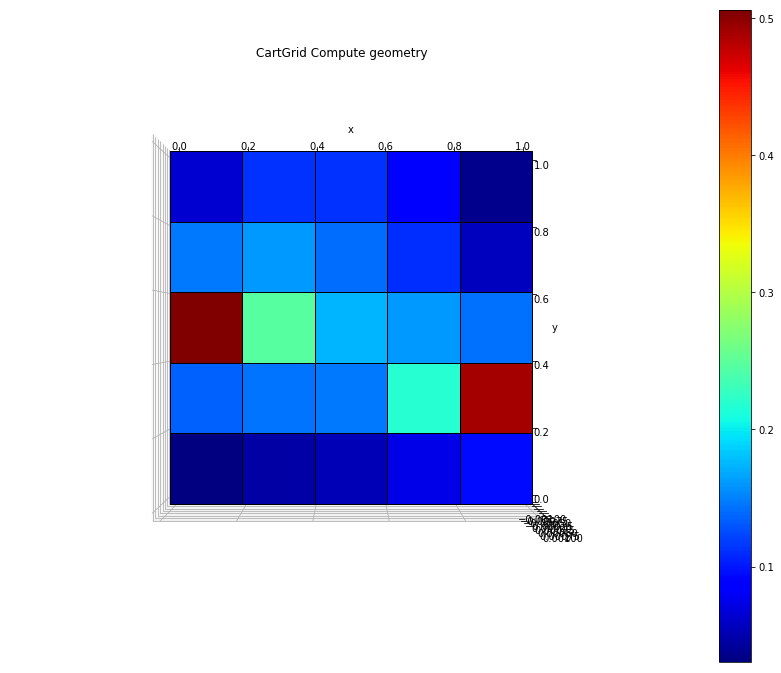

In [28]:
pp.plot_grid(g, p, figsize=(15,12))

In [ ]:
class FlowWeirdGrid(Flow):
    
    def create_grid(self):
        g = pp.GridBucket()

flow2 = FlowWirdGrid('TPFA',False)